# This notebook is to study the difference between norminal gen/reco and the projections of resp, and also the difference between the corresponding unfolded results

In [22]:
import ROOT as rt
import array as array
import os
import glob
from random import gauss
import numpy as np
import root_numpy as rtnpy
import pandas as pd
import h5py
from awkward import JaggedArray, Table
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.insert(0,'/t3home/gelliu/Unfolding_Substructure/CMSSW_10_6_5/python/jetObservables/Unfolding')
import CMS_lumi,tdrstyle
tdrstyle.setTDRStyle()
rt.gROOT.SetBatch()
rt.gROOT.ForceStyle()
rt.gStyle.SetOptStat(0)

In [2]:
lumi=5750+2573+4242+4025+3104+7576+8632
print lumi
CrossSection=np.array([1.172e5,7.76e3,642.1,185.9,32.05,9.365,0.8398,0.1124,0.006752,0.0001626,3.205e8])
EventNumber=np.array([6730737.00,4150588.00,3815049.25,3371704.00,2008088.12,1156036.00,174078.00,154791.00,154929.00,125457.00,248842.97])
#CrossSection=3.205e8
#EventNumber=248842.97
Scale=lumi*CrossSection/EventNumber
print Scale
MC_Compo=['QCD Pt170to300','QCD Pt300to470','QCD Pt470to600','QCD Pt600to800','QCD Pt800to1000','QCD Pt1000to1400','QCD Pt1400to1800','QCD Pt1800to2400','QCD Pt2400to3200','QCD Pt3200toInf','QCD Herwigg++']
print len(Scale),len(MC_Compo)
#MC_Compo=np.array(['QCD Flat','QCD Pt170to300','QCD Pt300to470','QCD Pt470to600','QCD Pt600to800','QCD Pt800to1000','QCD Pt1000to1400','QCD Pt1400to1800','QCD Pt1800to2400','QCD Pt2400to3200','QCD Pt3200toInf'])

35902
[6.25149133e+02 6.71229040e+01 6.04256267e+00 1.97946848e+00
 5.73012254e-01 2.90840623e-01 1.73201091e-01 2.60698930e-02
 1.56465416e-03 4.65312035e-05 4.62403700e+07]
11 11


In [3]:
fData=[]
path='/work/algomez/work/Files/jetObservables/v04/jetObservables_histograms_JetHT2016*.root'
files=glob.glob(path)
for f in files:
    fData.append(f)
print len(fData)
fMC=[
    '/work/algomez/work/Files/jetObservables/v04/jetObservables_histograms_QCD_Pt170to300.root',
    '/work/algomez/work/Files/jetObservables/v04/jetObservables_histograms_QCD_Pt300to470.root',
    '/work/algomez/work/Files/jetObservables/v04/jetObservables_histograms_QCD_Pt470to600.root',
    '/work/algomez/work/Files/jetObservables/v04/jetObservables_histograms_QCD_Pt600to800.root',
    '/work/algomez/work/Files/jetObservables/v04/jetObservables_histograms_QCD_Pt800to1000.root',
    '/work/algomez/work/Files/jetObservables/v04/jetObservables_histograms_QCD_Pt1000to1400.root',
    '/work/algomez/work/Files/jetObservables/v04/jetObservables_histograms_QCD_Pt1400to1800.root',
    '/work/algomez/work/Files/jetObservables/v04/jetObservables_histograms_QCD_Pt1800to2400.root',
    '/work/algomez/work/Files/jetObservables/v04/jetObservables_histograms_QCD_Pt2400to3200.root',
    '/work/algomez/work/Files/jetObservables/v04/jetObservables_histograms_QCD_Pt3200toInf.root',
    '/work/algomez/work/Files/jetObservables/v04/jetObservables_histograms_QCD_Herwigpp.root'
]
print len(fMC)

7
11


In [4]:
def Fill1D(h0,h,bins):
    N=h0.GetNbinsX()
    content=np.zeros((len(bins)-1),dtype=float)
    for i in range(len(bins)-1):
        content[i]=0
    for i in range(N):
        center=h0.GetBinCenter(i+1)
        index=np.digitize(np.array([center]),bins)
        if index[0] < len(bins):
            content[index[0]-1]+=h0.GetBinContent(i+1)
    for i in range(len(bins)-1):
        h.SetBinContent(i+1,content[i])

def Fill2D(h0,h,binx,biny):
    Nx=h0.GetNbinsX()
    Ny=h0.GetNbinsY()
    hx=h0.ProjectionX()
    hy=h0.ProjectionY()
    content=np.zeros((len(binx)-1,len(biny)-1),dtype=float)
    for i in range(len(binx)-1):
        for j in range(len(biny)-1):
            content[i][j]=0
    for i in range(Nx):
        for j in range(Ny):
            centerx=hx.GetBinCenter(i+1)
            indexx=np.digitize(np.array([centerx]),binx)
            centery=hy.GetBinCenter(j+1)
            indexy=np.digitize(np.array([centery]),biny)
            if indexx[0] < len(binx) and indexy[0] < len(biny):
                content[indexx[0]-1][indexy[0]-1]+=h0.GetBinContent(i+1,j+1)
    for i in range(len(binx)-1):
        for j in range(len(biny)-1):
            h.SetBinContent(i+1,j+1,content[i][j])

In [5]:
def DoUnfolding(Response,Reco):
    tunfolder = rt.TUnfoldDensity(Response,rt.TUnfold.kHistMapOutputHoriz,rt.TUnfold.kRegModeCurvature, rt.TUnfold.kEConstraintNone, rt.TUnfoldDensity.kDensityModeBinWidth)
    tunfolder.SetInput(Reco)
    tunfolder.DoUnfold(0.)
    unf=tunfolder.GetOutput("MC_unfolded")
    N=unf.GetNbinsX()
    cov_total=tunfolder.GetEmatrixTotal("Total Covariance Matrix")
    for i in range(1,N+1):
        stat=cov_total.GetBinContent(i,i)
        unf.SetBinError(i,np.sqrt(stat))
    return unf

In [6]:
reco='recoJet1_tau_1_3_nom_dijetSel'
fake='fakerecoJet1_tau_1_3_dijetSel'
gen='genJet1_tau_1_3_dijetSel'
response='respJet1_tau_1_3_nom_dijetSel'

425474.991398 423082.017035 423502.048968


Warning in <TROOT::Append>: Replacing existing TH1: MC3_reco0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC3_gen0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Response3 (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c0


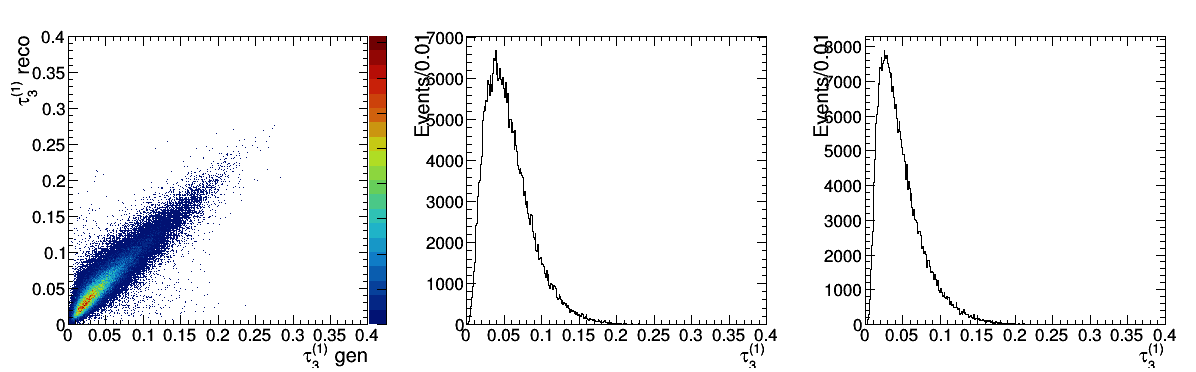

In [34]:
MC3_reco0=rt.TH1D("MC3_reco0","MC3_reco0;#tau_{3}^{(1)};Events/0.01",400,0,0.4)
MC3_gen0=rt.TH1D("MC3_gen0","MC3_gen0;#tau_{3}^{(1)};Events/0.01",400,0,0.4)
Response3_0=rt.TH2D("Response3","Response3;#tau_{3}^{(1)} gen;#tau_{3}^{(1)} reco",400,0,0.4,400,0,0.4)

f_MC=rt.TFile.Open(fMC[len(fMC)-1],'read')
t=f_MC.Get('jetObservables')
MC3_reco0.Add(t.Get(reco),Scale[len(fMC)-1])
#MC3_fake0.Add(t.Get(fake),Scale[len(fMC)-1])
MC3_gen0.Add(t.Get(gen),Scale[len(fMC)-1])
Response3_0.Add(t.Get(response),Scale[len(fMC)-1])
f_MC.Close()

c0=rt.TCanvas("c0","c0",0,0,1200,400)
c0.Divide(3,1)
c0.cd(1)
Response3_0.Draw("Colz")
#Data_reco0.Draw("hist")
c0.cd(2)
MC3_reco0.Draw("hist")
c0.cd(3)
MC3_gen0.Draw("hist")
c0.Draw()
print Response3_0.Integral(),MC3_reco0.Integral(),MC3_gen0.Integral()

In [8]:
gen_bin=np.array([0.0,0.032,0.064,0.096,0.128,0.16,0.192,0.224,0.3])
reco_bin=np.array([0.0,0.016,0.032,0.048,0.064,0.08,0.096,0.112,0.128,0.144,0.16,0.176,0.192,0.208,0.224,0.25,0.3])

In [46]:
MC3_reco=rt.TH1D("MC_reco Herwigg++","MC_reco Herwigg++;#tau_{3}^{(1)};Events",reco_bin.shape[0]-1,reco_bin)
MC3_gen=rt.TH1D("MC_gen Herwigg++","MC_gen Herwigg++;#tau_{3}^{(1)};Events",gen_bin.shape[0]-1,gen_bin)
Response3=rt.TH2D("Response Matrix Herwigg++","Response Matrix Herwigg++;#tau_{3}^{(1)} gen;#tau_{3}^{(1)} reco",gen_bin.shape[0]-1,gen_bin,reco_bin.shape[0]-1,reco_bin)

Fill1D(MC3_reco0,MC3_reco,reco_bin)
Fill1D(MC3_gen0,MC3_gen,gen_bin)
Fill2D(Response3_0,Response3,gen_bin,reco_bin)

MC3_recop=rt.TH1D("MC_reco Herwigg++ (projection)","MC_reco Herwigg++ (projection);#tau_{3}^{(1)};Events",reco_bin.shape[0]-1,reco_bin)
MC3_recop.Add(Response3.ProjectionY())
MC3_genp=rt.TH1D("MC_gen Herwigg++ (projection)","MC_gen Herwigg++ (projection);#tau_{3}^{(1)};Events",gen_bin.shape[0]-1,gen_bin)
MC3_genp.Add(Response3.ProjectionX())

True

Warning in <TROOT::Append>: Replacing existing TH1: MC_reco Herwigg++ (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC_gen Herwigg++ (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Response Matrix Herwigg++ (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC_reco Herwigg++ (projection) (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC_gen Herwigg++ (projection) (Potential memory leak).


MC_reco: 423082.017035
MC_reco projection: 425474.991398
Difference: 0.0056401027629

MC_gen: 423502.048968
MC_gen projection: 425474.991398
Difference: 0.00464781103951


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


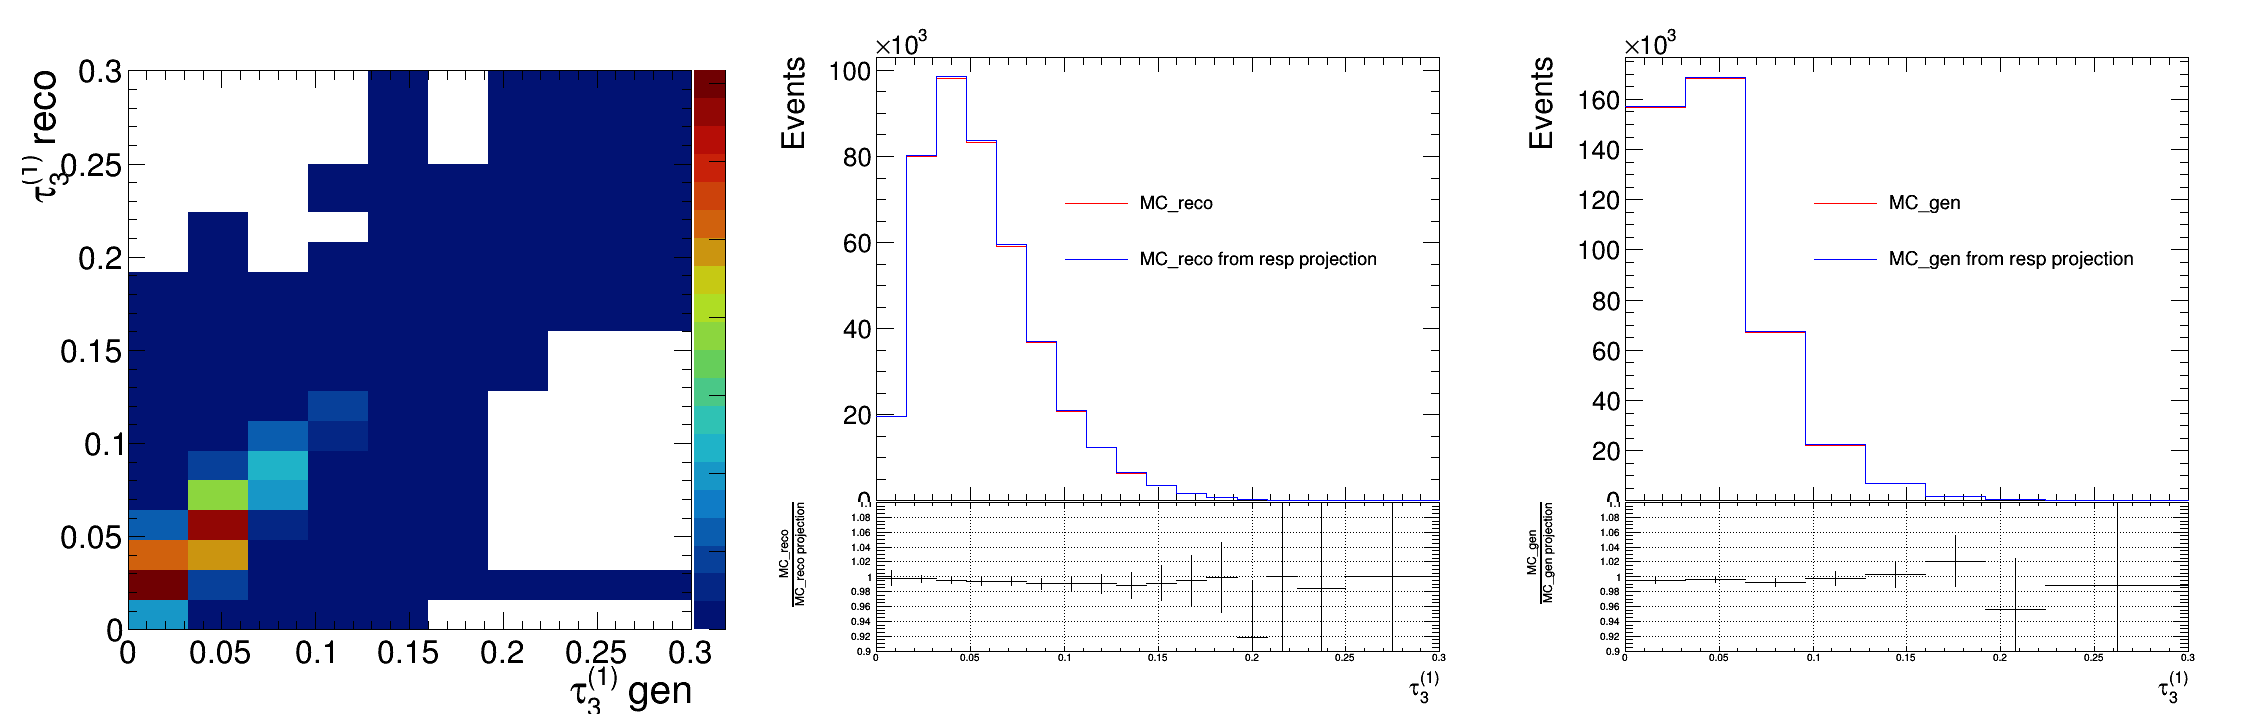

In [47]:
c1=rt.TCanvas("c1","c1",0,0,750*3,750)
c1.Divide(3,1)

c1.cd(1)
Response3.SetStats(0)
Response3.Draw("Colz")

c1.cd(2)
rt.tdrStyle.SetPadRightMargin(0.05)
rt.tdrStyle.SetPadLeftMargin(0.15)
pad11=rt.TPad("pad11","Main",0,0.207,1.00,1.00,-1)
pad12=rt.TPad("pad12","Ratio",0,0.00,1.00,0.30,-1)
pad11.Draw()
pad12.Draw()
pad11.cd()
MC3_reco.SetStats(0)
MC3_recop.SetStats(0)
MC3_reco.SetLineColor(rt.kRed)
MC3_recop.SetLineColor(rt.kBlue)
l1=rt.TLegend(.4,.5,.9,.7)
l1.AddEntry(MC3_reco,"MC_reco","l")
l1.AddEntry(MC3_recop,"MC_reco from resp projection","l")
MC3_reco.Draw("hist")
MC3_recop.Draw("histsame")
l1.Draw("Same")
pad12.cd()
rt.gStyle.SetOptFit(1)
pad12.SetGridx()
pad12.SetGridy()
pad12.SetTopMargin(0)
pad12.SetBottomMargin(0.3)
MC3_reco.Sumw2()
MC3_recop.Sumw2()
ratio1=MC3_reco.Clone("ratio")
ratio1.Divide(MC3_recop)
ratio1.GetYaxis().SetTitle("#frac{MC_reco}{MC_reco projection}")
ratio1.GetYaxis().SetRangeUser(0.9,1.1)
ratio1.GetXaxis().SetTitleSize(0.12)
ratio1.SetLineColor(rt.kBlack)
ratio1.Draw("e")

c1.cd(3)
pad21=rt.TPad("pad11","Main",0,0.207,1.00,1.00,-1)
pad22=rt.TPad("pad12","Ratio",0,0.00,1.00,0.30,-1)
pad21.Draw()
pad22.Draw()
pad21.cd()
MC3_gen.SetStats(0)
MC3_genp.SetStats(0)
MC3_gen.SetLineColor(rt.kRed)
MC3_genp.SetLineColor(rt.kBlue)
l2=rt.TLegend(.4,.5,.9,.7)
l2.AddEntry(MC3_gen,"MC_gen","l")
l2.AddEntry(MC3_genp,"MC_gen from resp projection","l")
MC3_gen.Draw("hist")
MC3_genp.Draw("histsame")
l2.Draw("Same")
pad22.cd()
rt.gStyle.SetOptFit(1)
pad22.SetGridx()
pad22.SetGridy()
pad22.SetTopMargin(0)
pad22.SetBottomMargin(0.3)
MC3_gen.Sumw2()
MC3_genp.Sumw2()
ratio2=MC3_gen.Clone("ratio")
ratio2.Divide(MC3_genp)
ratio2.GetYaxis().SetTitle("#frac{MC_gen}{MC_gen projection}")
ratio2.GetYaxis().SetRangeUser(0.9,1.1)
ratio2.GetXaxis().SetTitleSize(0.12)
ratio2.SetLineColor(rt.kBlack)
ratio2.Draw("e")

c1.Draw()

print "MC_reco:",MC3_reco.Integral()
print "MC_reco projection:",MC3_recop.Integral()
print "Difference:",2*(MC3_recop.Integral()-MC3_reco.Integral())/(MC3_recop.Integral()+MC3_reco.Integral())
print "\nMC_gen:",MC3_gen.Integral()
print "MC_gen projection:",MC3_genp.Integral()
print "Difference:",2*(MC3_genp.Integral()-MC3_gen.Integral())/(MC3_genp.Integral()+MC3_gen.Integral())

In [48]:
unf=DoUnfolding(Response3,MC3_reco)
unfp=DoUnfolding(Response3,MC3_recop)

Info in <TUnfold::SetConstraint>: fConstraint=0
Info in <TUnfold::TUnfold>: underflow and overflow bin do not depend on the input data
Info in <TUnfold::TUnfold>: 16 input bins and 8 output bins
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #0 (xaxis:#tau_{3}^{(1)} gen[ufl])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #9 (xaxis:#tau_{3}^{(1)} gen[ofl])
Info in <TUnfoldDensity::RegularizeOneDistribution>: regularizing xaxis regMode=3 densityMode=1 axisSteering=*[UOB]
Warning in <TROOT::Append>: Replacing existing TH1: MC_unfolded (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Total Covariance Matrix (Potential memory leak).
Info in <TUnfold::SetConstraint>: fConstraint=0
Info in <TUnfold::TUnfold>: underflow and overflow bin do not depend on the input data
Info in <TUnfold::TUnfold>: 16 input bins and 8 output bins
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #0 (xaxis:#tau_{3}^{(1)} gen[ufl])
Info in <TUnfoldDensity::TUnfold>:

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created


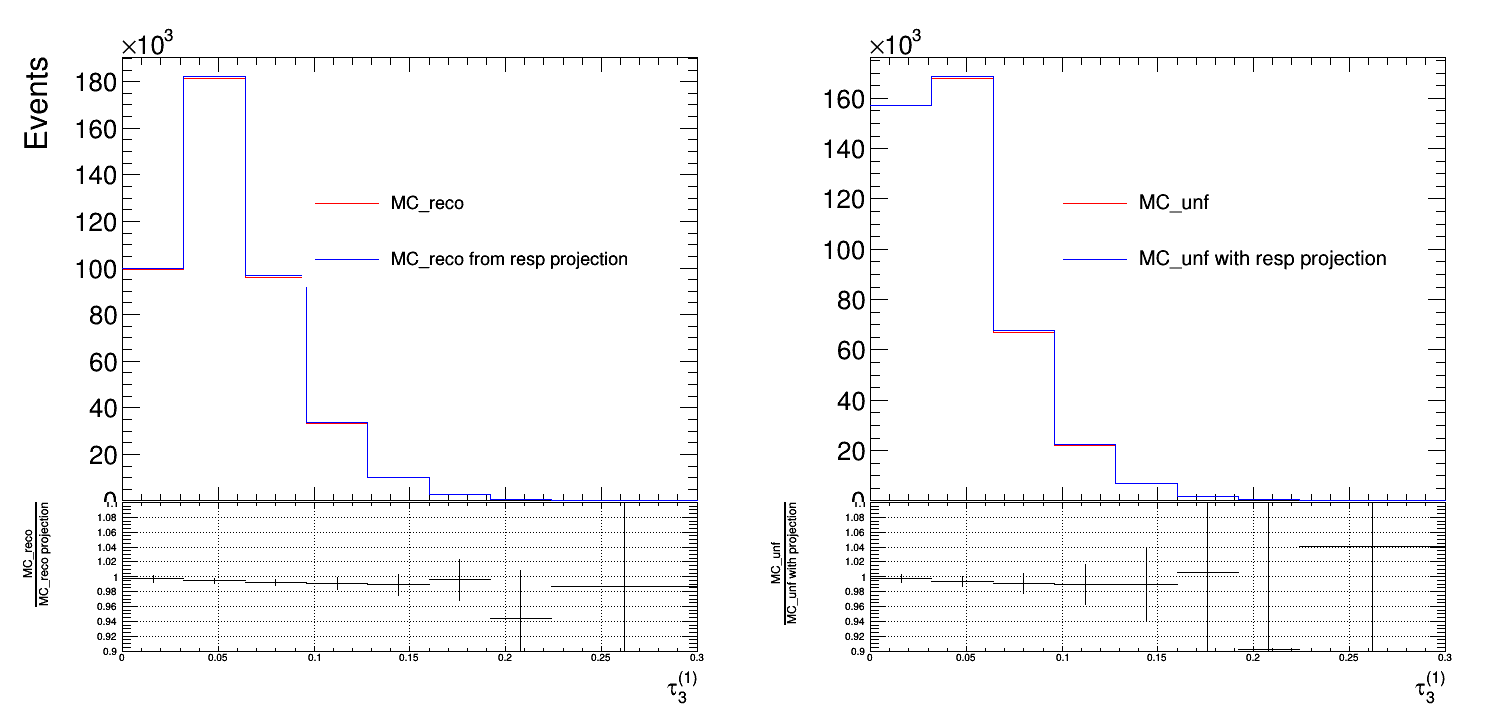

In [50]:
c2=rt.TCanvas("c2","c2",0,0,750*2,750)
c2.Divide(2,1)

c2.cd(1)
rt.tdrStyle.SetPadRightMargin(0.05)
rt.tdrStyle.SetPadLeftMargin(0.15)
pad11=rt.TPad("pad11","Main",0,0.207,1.00,1.00,-1)
pad12=rt.TPad("pad12","Ratio",0,0.00,1.00,0.30,-1)
pad11.Draw()
pad12.Draw()
pad11.cd()
MC3_reco.Sumw2()
MC3_recop.Sumw2()
MC3_reco.Rebin(2)
MC3_recop.Rebin(2)
MC3_reco.SetStats(0)
MC3_recop.SetStats(0)
MC3_reco.SetLineColor(rt.kRed)
MC3_recop.SetLineColor(rt.kBlue)
l1=rt.TLegend(.4,.5,.9,.7)
l1.AddEntry(MC3_reco,"MC_reco","l")
l1.AddEntry(MC3_recop,"MC_reco from resp projection","l")
MC3_reco.Draw("hist")
MC3_recop.Draw("histsame")
l1.Draw("Same")
pad12.cd()
rt.gStyle.SetOptFit(1)
pad12.SetGridx()
pad12.SetGridy()
pad12.SetTopMargin(0)
pad12.SetBottomMargin(0.3)
ratio1=MC3_reco.Clone("ratio")
ratio1.Divide(MC3_recop)
ratio1.GetYaxis().SetTitle("#frac{MC_reco}{MC_reco projection}")
ratio1.GetYaxis().SetRangeUser(0.9,1.1)
ratio1.GetXaxis().SetTitleSize(0.12)
ratio1.SetLineColor(rt.kBlack)
ratio1.Draw("e")

c2.cd(2)
pad21=rt.TPad("pad1","Main",0,0.207,1.00,1.00,-1)
pad22=rt.TPad("pad2","Ratio",0,0.00,1.00,0.30,-1)
pad21.Draw()
pad22.Draw()
pad21.cd()
unf.SetStats(0)
unfp.SetStats(0)
unf.SetLineColor(rt.kRed)
unfp.SetLineColor(rt.kBlue)
l2=rt.TLegend(.4,.5,.9,.7)
l2.AddEntry(unf,"MC_unf","l")
l2.AddEntry(unfp,"MC_unf with resp projection","l")
unf.Draw("hist")
unfp.Draw("histsame")
l2.Draw("Same")
pad22.cd()
rt.gStyle.SetOptFit(1)
pad22.SetGridx()
pad22.SetGridy()
pad22.SetTopMargin(0)
pad22.SetBottomMargin(0.3)
ratio2=unf.Clone("ratio")
ratio2.Divide(unfp)
ratio2.GetYaxis().SetTitle("#frac{MC_unf}{MC_unf with projection}")
ratio2.GetYaxis().SetRangeUser(0.9,1.1)
ratio2.GetXaxis().SetTitleSize(0.12)
ratio2.GetXaxis().SetTitle("#tau_{3}^{(1)}")
ratio2.SetLineColor(rt.kBlack)
ratio2.Draw("e")
c2.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c3


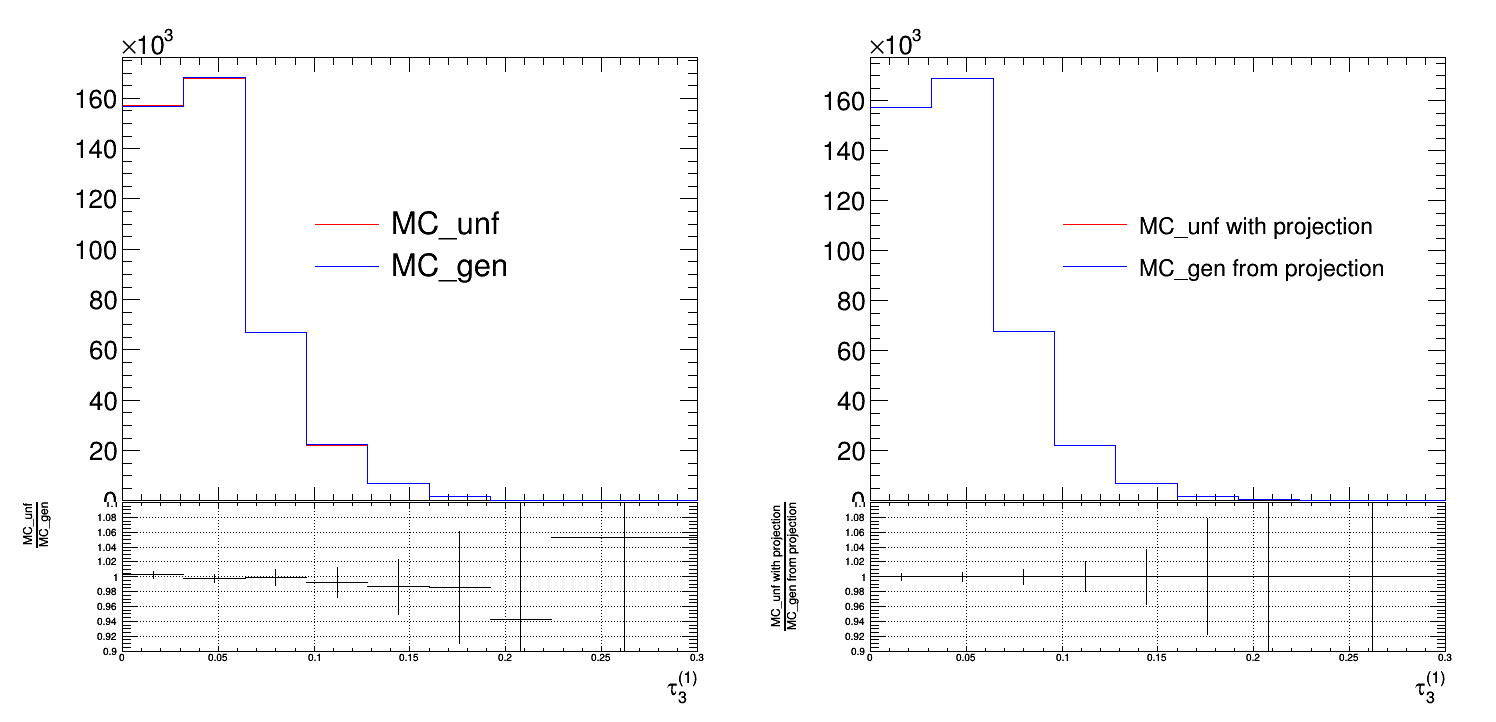

In [58]:
c3=rt.TCanvas("c3","c3",0,0,750*2,750)
c3.Divide(2,1)

c3.cd(1)
rt.tdrStyle.SetPadRightMargin(0.05)
rt.tdrStyle.SetPadLeftMargin(0.15)
pad11=rt.TPad("pad11","Main",0,0.207,1.00,1.00,-1)
pad12=rt.TPad("pad12","Ratio",0,0.00,1.00,0.30,-1)
pad11.Draw()
pad12.Draw()
pad11.cd()
unf.SetLineColor(rt.kRed)
MC3_gen.SetLineColor(rt.kBlue)
l1=rt.TLegend(.4,.5,.9,.65)
l1.AddEntry(unf,"MC_unf","l")
l1.AddEntry(MC3_gen,"MC_gen","l")
unf.Draw("hist")
MC3_gen.Draw("histsame")
l1.Draw("Same")
pad12.cd()
rt.gStyle.SetOptFit(1)
pad12.SetGridx()
pad12.SetGridy()
pad12.SetTopMargin(0)
pad12.SetBottomMargin(0.3)
ratio1=unf.Clone("ratio")
ratio1.Divide(MC3_gen)
ratio1.GetYaxis().SetTitle("#frac{MC_unf}{MC_gen}")
ratio1.GetYaxis().SetRangeUser(0.9,1.1)
ratio1.GetXaxis().SetTitleSize(0.12)
ratio1.GetXaxis().SetTitle("#tau_{3}^{(1)}")
ratio1.SetLineColor(rt.kBlack)
ratio1.Draw("e")

c3.cd(2)
pad21=rt.TPad("pad11","Main",0,0.207,1.00,1.00,-1)
pad22=rt.TPad("pad12","Ratio",0,0.00,1.00,0.30,-1)
pad21.Draw()
pad22.Draw()
pad21.cd()
unfp.SetLineColor(rt.kRed)
MC3_genp.SetLineColor(rt.kBlue)
l2=rt.TLegend(.4,.5,.9,.65)
l2.AddEntry(unfp,"MC_unf with projection","l")
l2.AddEntry(MC3_genp,"MC_gen from projection","l")
unfp.Draw("hist")
MC3_genp.Draw("histsame")
l2.Draw("Same")
pad22.cd()
rt.gStyle.SetOptFit(1)
pad22.SetGridx()
pad22.SetGridy()
pad22.SetTopMargin(0)
pad22.SetBottomMargin(0.3)
ratio2=unfp.Clone("ratio")
ratio2.Divide(MC3_genp)
ratio2.GetYaxis().SetTitle("#frac{MC_unf with projection}{MC_gen from projection}")
ratio2.GetYaxis().SetRangeUser(0.9,1.1)
ratio2.GetXaxis().SetTitleSize(0.12)
ratio2.GetXaxis().SetTitle("#tau_{3}^{(1)}")
ratio2.SetLineColor(rt.kBlack)
ratio2.Draw("e")

c3.Draw()